In [ ]:
pip install rouge

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from rouge import Rouge
import csv
import nltk
import random
import pickle
import re
from glob import glob
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Input, Dropout, LSTM, Embedding, Activation, Concatenate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Preprocessing Images**

In [ ]:
images_path = "/content/drive/MyDrive/Dataset/stanford_images/"
images = glob(images_path+'*.jpg')
print("Total images in dataset:",len(images))
for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

KeyboardInterrupt: ignored

In [ ]:
incept_model = ResNet50(include_top=True)
last = incept_model.layers[-2].output
CNNmodel = Model(inputs = incept_model.input,outputs = last)

In [ ]:
images_features = {}
count = 0
print("Converting images to features using CNN model")
for i in images:
   img = cv2.imread(i)
   img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   img = cv2.resize(img, (224,224))
   img = img.reshape(1,224,224,3)
   pred = CNNmodel.predict(img).reshape(2048,)
   img_name = i.split('/')[-1]
   images_features[img_name] = pred
   count += 1
   if count % 500 == 0:
       print("Completed for "+str(count)+" images")
print("length of image features:",len(images_features))
list(images_features.items())[:5]

In [ ]:
with open("/content/drive/MyDrive/Dataset/images_features/images_features.pkl","wb") as f:
   pickle.dump(images_features , f)

In [ ]:
with open("/content/drive/MyDrive/Dataset/images_features/images_features.pkl","rb") as f:
    images_features=pickle.load(f)

# **Preprocessing Captions and Creating Vocabulary**

In [ ]:
caption_path = '/content/drive/MyDrive/Dataset/stanford_df_rectified.csv'

with open(caption_path) as csvfile:
    captions=csv.reader(csvfile, delimiter=',', quotechar='"')
    captions_dict_train,captions_dict_test,captions_dict_val= {},{},{}
    for i in captions:
        try:
            img_name = i[0]  + ".jpg"
            caption = i[1]
            train_input=i[2]
            test_input=i[3]
            val_input=i[5]
            if img_name in images_features:
                if train_input=='True':
                    captions_dict_train[img_name] = caption
                elif test_input=='True':
                    captions_dict_test[img_name] = caption
                elif val_input=='True':
                    captions_dict_val[img_name] = caption
        except:
            pass

captions_dict_train_words = captions_dict_train.copy()
print("size of train, test and validation dataset:" ,len(captions_dict_train),len(captions_dict_test),len(captions_dict_val))

size of train, test and validation dataset: 14575 2489 2487


In [ ]:
def preprocessed(txt):
    modified = txt.lower().replace('.',' .').replace("'","")
    modified = 'startofseq ' + modified + ' endofseq'
    return modified

count_words = {}
print("Captions before preprocessing\n ",list(captions_dict_train.items())[:5])

for k,v in captions_dict_train.items():
    captions_dict_train[k]=preprocessed(v)

#creating count_words dict with word and frequency
for k,v in captions_dict_train.items():
    for word in v.split():
        if word not in count_words:
            count_words[word] = 1
        else:
            count_words[word] += 1

#creating words_dict as vocabulary where only words occuring more than threshold is considered
THRESH = 5
count = 1
words_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        words_dict[k] = count
        count += 1

#captions_dict converting words into numbers from words_dict
for k, v in captions_dict_train.items():
    encoded = []
    for word in v.split():
        if word in words_dict.keys():
            encoded.append(words_dict[word])

    captions_dict_train[k] = encoded

print("Captions after preprocessing\n ",list(captions_dict_train.items())[:5])

Captions before preprocessing
  [('2317429.jpg', 'A white round plate is on a table with a plastic tablecloth on it.  Two foil covered food halves are on the white plate along with a serving of golden yellow french fries.  Next to the white plate in a short,  topless, plastic container is a white sauce.  Diagonal to the white plate are the edges of several other stacked plates.  There are black shadows reflected on the table.'), ('2365091.jpg', 'A large red and white train is traveling on tracks in a what looks to be a rural area. There are trees and hills in the background and the ground looks dry. The train has many large windows for the passengers to look out of. The train is mostly white with red on the front upper part of the train and red stripes and trim on the sides. The roof of the train is grey.'), ('2383120.jpg', 'A very clean and tidy a bathroom. Everything is a neat porcelain white. This bathroom is both retro and modern.'), ('2333990.jpg', 'There are four small pizzas on 

# **Model Creation**

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 271)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 271, 271)     1063946     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              

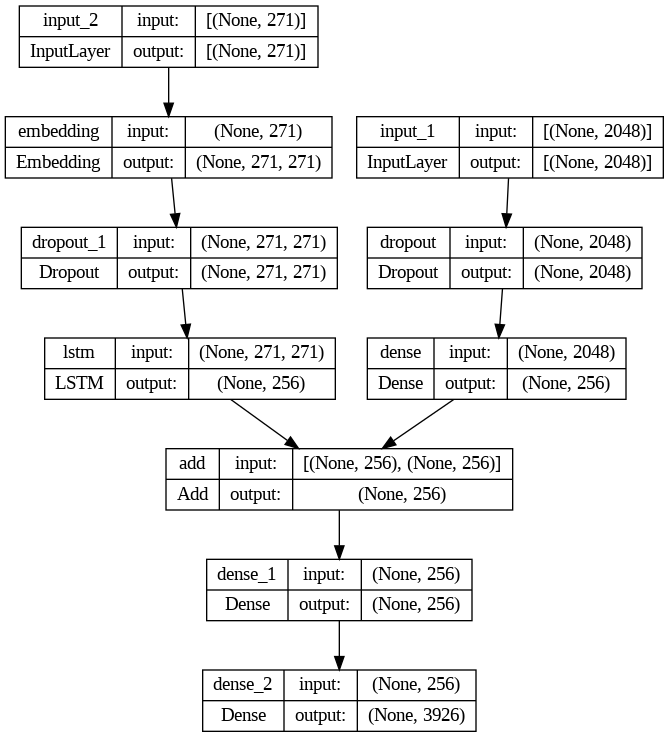

In [ ]:
vocab_size = len(words_dict)+1
MAX_LEN = 0

for k, v in captions_dict_train.items():
    if len(v) > MAX_LEN:
        MAX_LEN = len(v)

# feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# language sequence model
inputs2 = Input(shape=(MAX_LEN,))
se1 = Embedding(vocab_size, MAX_LEN, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Define your optimizer with the learning rate
optimizer = Adam(learning_rate=0.0001)

# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# summarize model
model.summary()
plot_model(model, show_shapes=True)

In [ ]:
model.layers[2]


# **Training RNN- Using Generator Function to create input**

In [ ]:
N=32 #BatchSize
VOCAB_SIZE = len(words_dict)+1

def progressive_generator(photo_dict, caption_dict, MAX_LEN,VOCAB_SIZE):
    while 1:
        for i in range(0,len(caption_dict),N):
            caption = dict(list(caption_dict.items())[0+i: N+i])
            X, y_in, y_out = create_sequences(photo_dict,caption,MAX_LEN, VOCAB_SIZE)
            yield [X, y_in], y_out


def create_sequences(photo, caption, MAX_LEN,VOCAB_SIZE):
    #n_samples = 0
    X,y_in,y_out = [],[],[]

    for k, v in caption.items():
        for i in range(1, len(v)):
            X.append(photo[k])

            in_seq= [v[:i]]
            out_seq = v[i]

            in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
            out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

            y_in.append(in_seq)
            y_out.append(out_seq)

    return np.array(X), np.array(y_in), np.array(y_out)

In [ ]:
steps = len(captions_dict_train)//N
generator = progressive_generator(images_features, captions_dict_train, MAX_LEN, VOCAB_SIZE)

In [ ]:
print('steps:',steps)

steps: 455


In [ ]:
# Define the filepath for saving model weights
filepath = "/content/drive/MyDrive/Dataset/model150/model_weights_{epoch:02d}.h5"

In [ ]:
# Create an instance of the checkpoint callback
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, period=1)

In [ ]:
# Save the model architecture to a JSON string
model_architecture = model.to_json()

# Write the JSON string to a file
with open('/content/drive/MyDrive/Dataset/model150/model150_architecture.json', 'w') as f:
    f.write(model_architecture)

In [ ]:
history = model.fit(generator, epochs=150, steps_per_epoch=steps, verbose=1, callbacks=[checkpoint])

Epoch 1/150
455/455 [==============================] - 141s 291ms/step - loss: 5.3041 - accuracy: 0.1273
Epoch 2/150
455/455 [==============================] - 95s 209ms/step - loss: 4.4144 - accuracy: 0.2481
Epoch 3/150
455/455 [==============================] - 95s 208ms/step - loss: 3.9332 - accuracy: 0.2959
Epoch 4/150
455/455 [==============================] - 95s 209ms/step - loss: 3.7007 - accuracy: 0.3178
Epoch 5/150
455/455 [==============================] - 95s 208ms/step - loss: 3.5434 - accuracy: 0.3364
Epoch 6/150
455/455 [==============================] - 95s 209ms/step - loss: 3.4343 - accuracy: 0.3475
Epoch 7/150
455/455 [==============================] - 95s 209ms/step - loss: 3.3525 - accuracy: 0.3555
Epoch 8/150
455/455 [==============================] - 95s 209ms/step - loss: 3.2849 - accuracy: 0.3617
Epoch 9/150
455/455 [==============================] - 95s 208ms/step - loss: 3.2304 - accuracy: 0.3672
Epoch 10/150
455/455 [==============================] - 95s 209

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [ ]:
train_loss = history.history['loss']
train_acc  = history.history['accuracy']

# Save accuracy and loss values to a file
with open('/content/drive/MyDrive/Dataset/model150/accuracy_loss.pkl', 'wb') as f:
    pickle.dump((train_acc, train_loss), f)

In [ ]:
# Load accuracy and loss values from the saved file
with open('/content/drive/MyDrive/Dataset/model150/accuracy_loss.pkl', 'rb') as f:
    accuracy_values, loss_values = pickle.load(f)

In [ ]:
model.save('/content/drive/MyDrive/Dataset/model150/image_caption_model_neewarch150' + '.h5')

In [ ]:
# Load the saved model architecture from the file
with open('/content/drive/MyDrive/Dataset/model150/model150_architecture.json', 'r') as f:
    model_architecture = f.read()

# Create a new model from the saved architecture
model = model_from_json(model_architecture)

model.load_weights('/content/drive/MyDrive/Dataset/model150/model_weights_100.h5')

# Define your optimizer with the learning rate
optimizer = Adam(learning_rate=0.0001)

# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Continue training the model with new data
history = model.fit(generator,
          epochs=150,
          steps_per_epoch=steps,
          verbose=1,
          callbacks=[checkpoint],
          initial_epoch=100,  # start from where you left off (i.e., epoch 10)
)

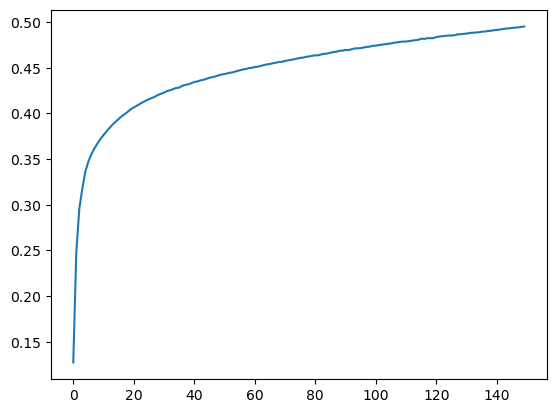

In [ ]:
xc         = range(150)

plt.figure()
plt.plot(xc, accuracy_values)

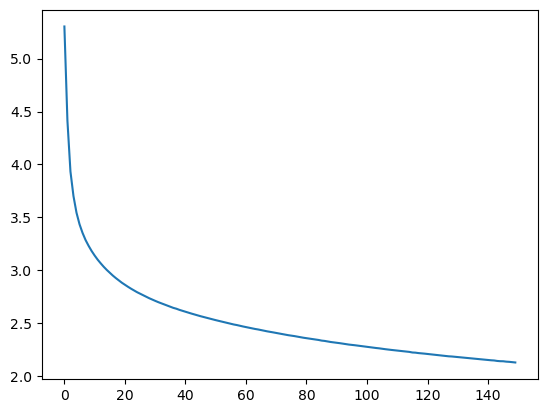

In [ ]:
# visualizing losses and accuracy
xc         = range(150)

plt.figure()
plt.plot(xc, loss_values)

In [ ]:
print('accuracy_values',accuracy_values)
print('loss_values',loss_values)

accuracy_values [0.12730789184570312, 0.24806177616119385, 0.2959284782409668, 0.3177776038646698, 0.33640313148498535, 0.34747835993766785, 0.3554920554161072, 0.3617172837257385, 0.3672005832195282, 0.3722594678401947, 0.3764508068561554, 0.3804205060005188, 0.38414591550827026, 0.38792407512664795, 0.39095616340637207, 0.3938807249069214, 0.3969587981700897, 0.3992043137550354, 0.401864230632782, 0.40468716621398926, 0.40660515427589417, 0.40839916467666626, 0.41038984060287476, 0.41231203079223633, 0.4141249358654022, 0.4155885875225067, 0.4171433746814728, 0.4184447228908539, 0.42034295201301575, 0.42156562209129333, 0.4228135645389557, 0.42457088828086853, 0.42542076110839844, 0.4266864061355591, 0.427933931350708, 0.4283199906349182, 0.43032196164131165, 0.4312058389186859, 0.431905597448349, 0.4332095682621002, 0.43450653553009033, 0.4350969195365906, 0.4362012445926666, 0.4368678033351898, 0.43795865774154663, 0.4391057789325714, 0.43986260890960693, 0.4405931234359741, 0.4417

# **Prediction**

In [ ]:
vocab_size = len(words_dict)+1
MAX_LEN = 0

for k, v in captions_dict_train.items():
    if len(v) > MAX_LEN:
        MAX_LEN = len(v)

inv_dict = {v:k for k, v in words_dict.items()}

In [ ]:
model150 = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/model150/image_caption_model_neewarch150.h5')

In [ ]:
img_name='2394335.jpg'
test_feature = images_features[img_name]
test_img_path = '/content/drive/MyDrive/Dataset/stanford_images/'+img_name
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


text_inp = ['startofseq']
count = 0
caption = ''
while count < MAX_LEN:
    count += 1
    encoded = []
    for i in text_inp:
        encoded.append(words_dict[i])
    encoded = [encoded]
    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
    data_list=[np.array(test_feature).reshape(1,-1), np.array(encoded).reshape(1,-1)]
    prediction = np.argmax(model150.predict(data_list))
    sampled_word = inv_dict[prediction]
    caption = caption + ' ' + sampled_word

    if sampled_word == 'endofseq':
        break
    text_inp.append(sampled_word)

caption= caption.replace('endofseq','')
predicted= caption.split()
actual= captions_dict_test[img_name].split()

1/1 [==============================] - 0s 45ms/step


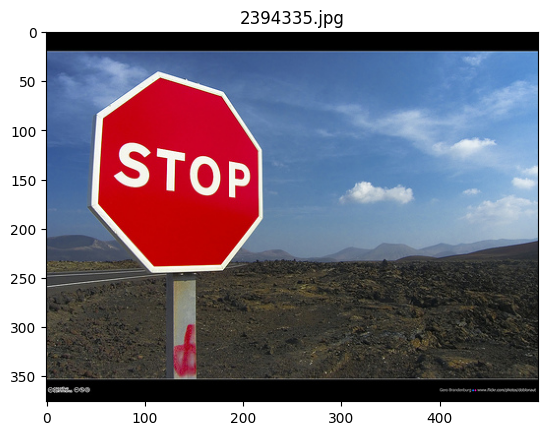

 a stop sign is attached to a pole. the sign is octagon. the sign is red. the sign is red. the sign is on a pole. the sign is white. the sign is on a pole. the sign is white. the sign is on a pole. the sign is white. the sky above the sign is blue. there are many clouds in the sky. 


In [ ]:
plt.figure()
plt.imshow(test_img)
plt.title(img_name)
plt.show()
print(caption.replace(' .','.'))

In [ ]:
img_name='2364210.jpg'
test_feature = images_features[img_name]
test_img_path = '/content/drive/MyDrive/Dataset/stanford_images/'+img_name
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


text_inp = ['startofseq']
count = 0
caption = ''
while count < MAX_LEN:
    count += 1
    encoded = []
    for i in text_inp:
        encoded.append(words_dict[i])
    encoded = [encoded]
    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)
    data_list=[np.array(test_feature).reshape(1,-1), np.array(encoded).reshape(1,-1)]
    prediction = np.argmax(model150.predict(data_list))
    sampled_word = inv_dict[prediction]
    caption = caption + ' ' + sampled_word

    if sampled_word == 'endofseq':
        break
    text_inp.append(sampled_word)

caption= caption.replace('endofseq','')
predicted= caption.split()
actual= captions_dict_test[img_name].split()

1/1 [==============================] - 0s 24ms/step


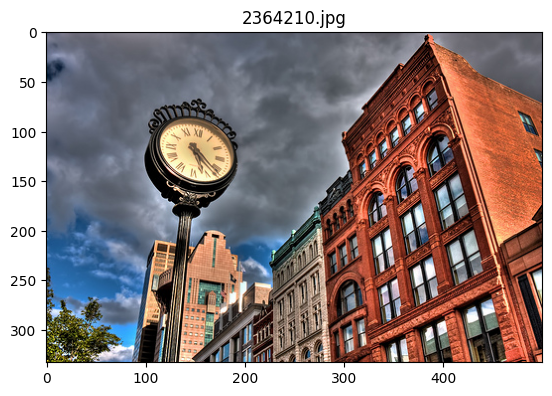

 a clock tower is attached to a building. the tower is made of metal. the clock is black. the clock has roman numerals. the clock has roman numerals. the clock has roman numerals. the hands of the clock are black. the clock is made of metal. the clock is made of metal. the clock has roman numerals. the sky above is gray. 


In [ ]:
plt.figure()
plt.imshow(test_img)
plt.title(img_name)
plt.show()
print(caption.replace(' .','.'))

# **Evaluation of Image Paragraph Captioning**

In [ ]:
# Tokenize the reference and generated captions
reference_tokens = [[word.lower() for word in text.split()] for text in actual]
generated_tokens = [[word.lower() for word in text.split()] for text in predicted]

# Flatten the nested list and convert it to a single string
reference_string = ' '.join([item for sublist in reference_tokens for item in sublist])
generated_string = ' '.join([item for sublist in generated_tokens for item in sublist])

In [ ]:
print('Reference caption:',reference_string)
print('Generated caption:',generated_string)

Reference caption: a red and white stop sign is on top of a pole. the pole is silver and has red writing on the front of it. there are black rocks in front of the sign on the ground.
Generated caption: a stop sign is attached to a pole . the sign is octagon . the sign is red . the sign is red . the sign is on a pole . the sign is white . the sign is on a pole . the sign is white . the sign is on a pole . the sign is white . the sky above the sign is blue . there are many clouds in the sky .


In [ ]:
# Calculate the BLEU score
# Equal weights for 1-gram to 4-gram
bleu_score1 = nltk.translate.bleu_score.sentence_bleu([reference_string], generated_string, weights = (1, 0, 0, 0))
bleu_score2 = nltk.translate.bleu_score.sentence_bleu([reference_string], generated_string, weights = (0.5, 0.5, 0, 0))
bleu_score3 = nltk.translate.bleu_score.sentence_bleu([reference_string], generated_string, weights = (0.3, 0.3, 0.3, 0))
bleu_score4 = nltk.translate.bleu_score.sentence_bleu([reference_string], generated_string, weights = (0.25, 0.25, 0.25, 0.25))

# Print the BLEU score
print("BLEU-1 Score:", bleu_score1)
print("BLEU-2 Score:", bleu_score2)
print("BLEU-3 Score:", bleu_score3)
print("BLEU-4 Score:", bleu_score4)
#indicates that the generated text may have higher precision in terms of individual words rather than four-word sequences.

BLEU-1 Score: 0.5119453924914675
BLEU-2 Score: 0.43715318066044195
BLEU-3 Score: 0.4100536383353209
BLEU-4 Score: 0.3195072580154937


In [ ]:
rouge_scorer = Rouge()
scores = rouge_scorer.get_scores(' '.join(generated_string), ' '.join(reference_string))
rouge_score1 = scores[0]['rouge-1']['f']
rouge_score2 = scores[0]['rouge-2']['f']
print('Rouge Score 1:',rouge_score1)
print('Rouge Score 2:',rouge_score2)

Rouge Score 1: 0.9268292632956573
Rouge Score 2: 0.5755395633517935


# **Fill in the blank Generation Training**

In [ ]:
! pip install transformers
! pip install --upgrade accelerate
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 128.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.0 MB/s eta 0:00:00


In [ ]:
import torch
from datasets import load_dataset, list_datasets
from sklearn.model_selection import train_test_split
from transformers import GPTNeoForCausalLM, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Load the dataset
dataset = pd.read_csv('/content/drive/MyDrive/Dataset/gpt-neo/fitb_df.csv')

In [ ]:
raw_sentence = dataset['sentence'].tolist()
question = dataset['question'].tolist()
answer = dataset['answer'].tolist()

In [ ]:
modified_paragraph = []
for i in raw_sentence :
   modified_paragraph.append("<CONTEXT_START> " + i + " <CONTEXT_END>")

modified_question = []
for i in question :
   modified_question.append("<QUESTION_START> " + i + " <QUESTION_END>")

modified_answer = []
for i in answer :
   modified_answer.append("<ANSWER_START> " + i + " <ANSWER_END>")

In [ ]:
modified_paragraph[0]

'<CONTEXT_START> The Mouse That Was is a story of a mouse that lived for months in a little hole below a small tree <CONTEXT_END>'

In [ ]:
data = []

for i in range(len(modified_paragraph)):
  data.append(modified_paragraph[i] + " " +modified_question[i] + " " + modified_answer[i])

In [ ]:
data[1]

'<CONTEXT_START> The Mouse That Was is a story of a mouse that lived for months in a little hole below a small tree <CONTEXT_END> <QUESTION_START> the mouse that was is a story of a mouse that lived for ________ in a little hole below a small tree <QUESTION_END> <ANSWER_START> months <ANSWER_END>'

In [ ]:
len(data)

8105

In [ ]:
# Convert the list to a DataFrame
df = pd.DataFrame(data)

# Define the ratio for splitting the dataset (e.g., 80% for training, 20% for testing)
train_ratio = 0.8

# Split the dataset into training and test DataFrames
train_df, test_df = train_test_split(df, train_size=train_ratio, test_size=1 - train_ratio)

# Print the shapes of the training and test DataFrames
print("Training DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)

Training DataFrame shape: (6484, 1)
Test DataFrame shape: (1621, 1)


In [ ]:
train_df.to_csv("fitb_df_train.csv")
test_df.to_csv("fitb_df_test.csv")

In [ ]:
model_name = "EleutherAI/gpt-neo-125M"
model = GPTNeoForCausalLM.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

In [ ]:
dataset_train = TextDataset(
    tokenizer=tokenizer,
    file_path="/content/fitb_df_train.csv",
    block_size=128,  # Set an appropriate block size
)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
dataset_valid = TextDataset(
    tokenizer=tokenizer,
    file_path="/content/fitb_df_test.csv",
    block_size=128,  # Set an appropriate block size
)

In [ ]:
output_dir = "/content/drive/MyDrive/Dataset/gpt-neo/GPT_Neo_finetuned_fitb_epoch30/"

In [ ]:
training_args = TrainingArguments(
    output_dir = output_dir + "results/",
    num_train_epochs=30,  # Set an appropriate number of epochs
    per_device_train_batch_size=10,  # Set an appropriate batch size
    save_steps=10000,
    save_total_limit=2,
    overwrite_output_dir=True,
    learning_rate=1e-4,
    logging_dir= output_dir + "logs/",
    logging_steps=100,
    save_strategy="steps",
)

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset = dataset_valid,
    data_collator=data_collator,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,1.437500
200,1.129000
300,1.002100
400,0.871900
500,0.706200
600,0.630600
700,0.603600
800,0.564700
900,0.472900
1000,0.444000


TrainOutput(global_step=12540, training_loss=0.1562240847084891, metrics={'train_runtime': 4447.5078, 'train_samples_per_second': 28.135, 'train_steps_per_second': 2.82, 'total_flos': 8171211022663680.0, 'train_loss': 0.1562240847084891, 'epoch': 30.0})

In [ ]:
model.eval()

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_fe

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Dataset/gpt-neo/FITB_GPT_Neo_finetuned_fitb_epoch30")
# tokenizer.save_pretrained("/content/drive/MyDrive/finetuned_gptneo")

# **Fill in the blank Generation**

In [ ]:
output_dir = "/content/drive/MyDrive/Dataset/gpt-neo/FITB_GPT_Neo_finetuned_fitb_epoch30"

In [ ]:
model_name = "EleutherAI/gpt-neo-125M"
model = GPTNeoForCausalLM.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

In [ ]:
def convert_to_fill_in_the_blank(paragraph):

 # Tokenize the paragraph
    input_ids = tokenizer.encode(paragraph, add_special_tokens=False, return_tensors='pt')

    # Generate qa
    with torch.no_grad():
        output = model.generate(input_ids, max_length=100, do_sample=True)

    generated_fillqa = tokenizer.decode(output[0], skip_special_tokens=True)

    return generated_fillqa

In [ ]:
def remove_repeated_sentences(sentences):
    unique_sentences = set()
    for sentence in sentences:
        unique_sentences.add(sentence)
    return list(unique_sentences)

In [ ]:
# Split the paragraph into sentences using regex
sentences = re.split(r'\.\s*', caption)

# Add a space at the end of each sentence
sentences_with_space = [sentence + " " for sentence in sentences if sentence]

print(sentences_with_space)

[' a clock tower is attached to a building  ', 'the tower is made of metal  ', 'the clock is black  ', 'the clock has roman numerals  ', 'the clock has roman numerals  ', 'the clock has roman numerals  ', 'the hands of the clock are black  ', 'the clock is made of metal  ', 'the clock is made of metal  ', 'the clock has roman numerals  ', 'the sky above is gray  ']


In [ ]:
cleaned_para = remove_repeated_sentences(sentences_with_space)

In [ ]:
sentences_with_context = ["<CONTEXT_START> {} <CONTEXT_END>".format(sentence.strip()) for sentence in cleaned_para]
print(sentences_with_context)

['<CONTEXT_START> the clock has roman numerals <CONTEXT_END>', '<CONTEXT_START> the clock is made of metal <CONTEXT_END>', '<CONTEXT_START> the clock is black <CONTEXT_END>', '<CONTEXT_START> the tower is made of metal <CONTEXT_END>', '<CONTEXT_START> the sky above is gray <CONTEXT_END>', '<CONTEXT_START> a clock tower is attached to a building <CONTEXT_END>', '<CONTEXT_START> the hands of the clock are black <CONTEXT_END>']


In [ ]:
output = []

for sentence in sentences_with_context:
    converted_sentence = convert_to_fill_in_the_blank(sentence)
    output.append(converted_sentence)

print(output)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

['<CONTEXT_START> the clock has roman numerals <CONTEXT_END> <QUESTION_START> the ________ has roman numerals <QUESTION_END> <ANSWER_START> clock <ANSWER_END>\n7987,<CONTEXT_START> The field has an assortment of green plants which is closer to the camera than the buildings. <CONTEXT_END> <QUESTION_START> the field has', '<CONTEXT_START> the clock is made of metal <CONTEXT_END> <QUESTION_START> the ________ is made of metal <QUESTION_END> <ANSWER_START> clock <ANSWER_END>\n1158,"<CONTEXT_START>  Since the book is a lengthy one, you can make the bed-time routine entertaining with friends <CONTEXT_END> <QUESTION_START> since the book', '<CONTEXT_START> the clock is black <CONTEXT_END> <QUESTION_START> the clock is ________ <QUESTION_END> <ANSWER_START> black <ANSWER_END>\n1953,"<CONTEXT_START>  When it comes to nursery rhymes for kids, all children could first think about ‘Twinkle Twinkle Little Star,’ ‘Jack and Jill’ etc <CONTEXT_', '<CONTEXT_START> the tower is made of metal <CONTEXT_EN

In [ ]:
contexts = []
questions = []
answers = []

for pattern in output:
    # Removing unwanted sentences
    pattern = re.sub(r'\d+,".*', '', pattern)

    # Extracting the desired parts
    context_match = re.search(r'<CONTEXT_START>(.*?)<CONTEXT_END>', pattern)
    question_match = re.search(r'<QUESTION_START>(.*?)<QUESTION_END>', pattern)
    answer_match = re.search(r'<ANSWER_START>(.*?)<ANSWER_END>', pattern)

    # Checking if answer pattern is found
    if answer_match:
        answer = answer_match.group(1)
    else:
        pass
    if context_match:
        context = context_match.group(1)
    else:
        pass
    if question_match:
        question = question_match.group(1)
    else:
        pass

    # Appending to relevant lists
    contexts.append(context.strip())
    questions.append(question.strip())
    answers.append(answer.strip())

In [ ]:
# Printing the 30 epochs
print("Contexts:", contexts)
print("Questions:", questions)
print("Answers:", answers)

Contexts: ['the clock has roman numerals', 'the clock is made of metal', 'the clock is black', 'the tower is made of metal', 'the sky above is gray', 'a clock tower is attached to a building', 'the hands of the clock are black']
Questions: ['the ________ has roman numerals', 'the ________ is made of metal', 'the clock is ________', 'the tower is made of ________', 'the sky above is ________', 'a clock tower is ________ to a building', 'the hands of the ________ are black']
Answers: ['clock', 'clock', 'black', 'metal', 'gray', 'attached', 'clock']


# **Evaluation**

In [ ]:
reference = "<CONTEXT_START> a man is waiting outside of a window. <CONTEXT_END>"
actual_question = convert_to_fill_in_the_blank(reference)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
actual_question

'<CONTEXT_START> a man is waiting outside of a window. <CONTEXT_END> <QUESTION_START> a man is ________ outside of a window. <QUESTION_END> <ANSWER_START> waiting <ANSWER_END>\n1428,<CONTEXT_START>  The girl was given all luxury by the queen <CONTEXT_END> <QUESTION_START> the girl was given all luxury by'

In [ ]:
# Removing unwanted sentences
pattern = re.sub(r'\d+,".*', '', actual_question)

# Extracting the desired parts
context_match = re.search(r'<CONTEXT_START>(.*?)<CONTEXT_END>', pattern)
question_match = re.search(r'<QUESTION_START>(.*?)<QUESTION_END>', pattern)
answer_match = re.search(r'<ANSWER_START>(.*?)<ANSWER_END>', pattern)

In [ ]:
# Checking if answer pattern is found
if answer_match:
  answer = answer_match.group(1)
else:
  pass
if context_match:
  context = context_match.group(1)
else:
  pass
if question_match:
  question = question_match.group(1)
else:
  pass

In [ ]:
reference_sentence = 'a man is waiting outside of a window.'
reference_question = 'a ________ is waiting outside of a window .'
reference_answer = 'man'

In [ ]:
print("Hypothesis question :", question)
print("Hypothesis answer :", answer)

Hypothesis question :  a man is ________ outside of a window. 
Hypothesis answer :  waiting 


In [ ]:
# Tokenize the reference sentence and hypothesis
reference_sentence_tokens = reference_sentence.split()
hypothesis_tokens = (question + ' ' + answer).split()

# Calculate BLEU score with 4-gram precision
bleu_score1 = sentence_bleu([reference_sentence_tokens], hypothesis_tokens, weights=(1, 0, 0, 0))
bleu_score2 = sentence_bleu([reference_sentence_tokens], hypothesis_tokens, weights = (0.5, 0.5, 0, 0))
bleu_score3 = sentence_bleu([reference_sentence_tokens], hypothesis_tokens, weights = (0.3, 0.3, 0.3, 0))
bleu_score4 = sentence_bleu([reference_sentence_tokens], hypothesis_tokens, weights=(0.25, 0.25, 0.25, 0.25))

print("BLEU Score1:", bleu_score1)
print("BLEU Score2:", bleu_score2)
print("BLEU Score3:", bleu_score3)
print("BLEU Score4:", bleu_score4)

BLEU Score1: 0.8888888888888888
BLEU Score2: 0.7453559924999299
BLEU Score3: 0.6501674345898532
BLEU Score4: 0.4463236137853328


In [ ]:
rouge_scorer = Rouge()
scores = rouge_scorer.get_scores(' '.join(hypothesis_tokens), ' '.join(reference_sentence_tokens))
rouge_score1 = scores[0]['rouge-1']['f']
rouge_score2 = scores[0]['rouge-2']['f']
print('Rouge Score 1:',rouge_score1)
print('Rouge Score 2:',rouge_score2)

Rouge Score 1: 0.9333333283555556
Rouge Score 2: 0.6666666616888889




---



---

